In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


**Section 0: library imports**
- please run this to import all the libraries to use


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [3]:
# extract all the stock tickers from S&P 500
# <script src="https://gist.github.com/quantra-go-algo/ac5180bf164a7894f70969fa563627b2.js"></script>
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers['Symbol'].tolist()
# Replace . with - to meet Yahoo Finance ticker's format

tickers = [ticker.replace('.', '-') for ticker in tickers]
#print(tickers[:])
#len(tickers) # Ensure the total number of stock = 503

# Identidy and filter out stocks with less than ten years of trading history
excluded_tickers = {'SW', 'ENPH','ABNB','CARR','CEG','CRWD',
                    'CTVA','DAY','DOW','ETSY','FOX','FOXA',
                    'FTV','GDDY','GEHC','GEV','HLT','HPE',
                    'HWM','INVH','IR','KHC','KVUE','LW','MRNA',
                    'OTIS','ORVO','SOLV','UBER','VICI','VLTO','VST'}

valid_tickers = []
for ticker in tickers:
    if ticker not in excluded_tickers:
        valid_tickers.append(ticker)

#print(valid_tickers[:])
#print(len(valid_tickers))

In [4]:
# Past performance to include Global Financial crisis, European debt crisis, Covid-19 Pandemic
data = yf.download(valid_tickers, start="2008-07-01", end="2024-07-01")['Adj Close']

# Forward fill and Backward fill the NaN data
data.fillna(method='ffill', inplace=True)  
data.fillna(method='bfill', inplace=True)  

[*********************100%%**********************]  472 of 472 completed


In [5]:
#take quarterly average of daily data
daily_return = data.pct_change()
quarterly_return = data.resample('Q').ffill().pct_change()
quarterly_volatility = daily_return.resample('Q').std() * np.sqrt(200)


# Forward fill and Backward fill the NaN data for quarterly return and quarterly_volatility
quarterly_return.fillna(method='ffill', inplace=True)
quarterly_return.fillna(method='bfill', inplace=True)
quarterly_volatility.fillna(method='ffill', inplace=True)
quarterly_volatility.fillna(method='bfill', inplace=True)

# Remove the first row from returns and volatility since it is NaN
quarterly_return = quarterly_return.iloc[1:]
quarterly_volatility = quarterly_volatility.iloc[1:]

# Transpose the DataFrames
quarterly_return = quarterly_return.transpose()
quarterly_volatility = quarterly_volatility.transpose()

# Combine returns and volatility into one DataFrame
features = pd.concat([quarterly_return, quarterly_volatility], axis=1, keys=['Returns', 'Volatility'])

# Remove the excluded tickers from the features DataFrame
features = features.loc[~features.index.isin(excluded_tickers)]

In [6]:
# Standardize the features data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [7]:
# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

In [9]:
from sklearn.cluster import KMeans
# Apply K-mean
# K-means will produce different clusters for different initializations of the cluster centers
# Run k-means with multiple (random) initializations of clusters centers. Take the clustering with the lowest loss
n_init = 100 
kmeans = KMeans(n_clusters=7, n_init=n_init, random_state=26)
kmeans.fit_predict(pca_components)
kmeans_labels = kmeans.labels_

**Section : Anomaly Detection for the cluster data**

In [10]:
# Compute pairwise distances within a cluster
def compute_pairwise_distances(data):
    return cdist(data, data, 'euclidean')

# Reduce outliers based on the threshold using pairwise distance (max + min)/2, and then using that to calculate the Euclidean distance of all the data and removing any data that exceeds the threshold
def reduce_outliers(data, labels, threshold_factor=1):
    new_data = []
    new_labels = []
    valid_indices = []

    # Loop over each cluster
    for cluster_label in np.unique(labels):
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_data = data[cluster_indices]
        # No outlier if a cluster has 1 or fewer data points
        if len(cluster_data) <= 2:
            new_data.append(cluster_data)
            new_labels.extend([cluster_label] * len(cluster_data))
            valid_indices.extend(cluster_indices)
        else:
            # Compute the threshold for outlier detection
            pairwise_distances = compute_pairwise_distances(cluster_data)
            max_distance = np.max(pairwise_distances)
            min_distance = np.min(pairwise_distances)
            threshold = threshold_factor * (max_distance + min_distance) / 2
            # Compute the distances from the centroid
            centroid = np.mean(cluster_data, axis=0)
            distances_from_centroid = np.linalg.norm(cluster_data - centroid, axis=1)

            # Keep the non-outlier data
            for i, distance in enumerate(distances_from_centroid):
                if distance <= threshold:
                    new_data.append(cluster_data[i])
                    new_labels.append(cluster_label)
                    valid_indices.append(cluster_indices[i])

    return np.array(new_data), np.array(new_labels), valid_indices

In [11]:
# Reduce outliers for cluster data
reduced_data, reduced_labels, valid_indices = reduce_outliers(pca_components, kmeans_labels, threshold_factor=1)

In [12]:
# Get the list of tickers of the reduced data
reduced_tickers = features.index[valid_indices]

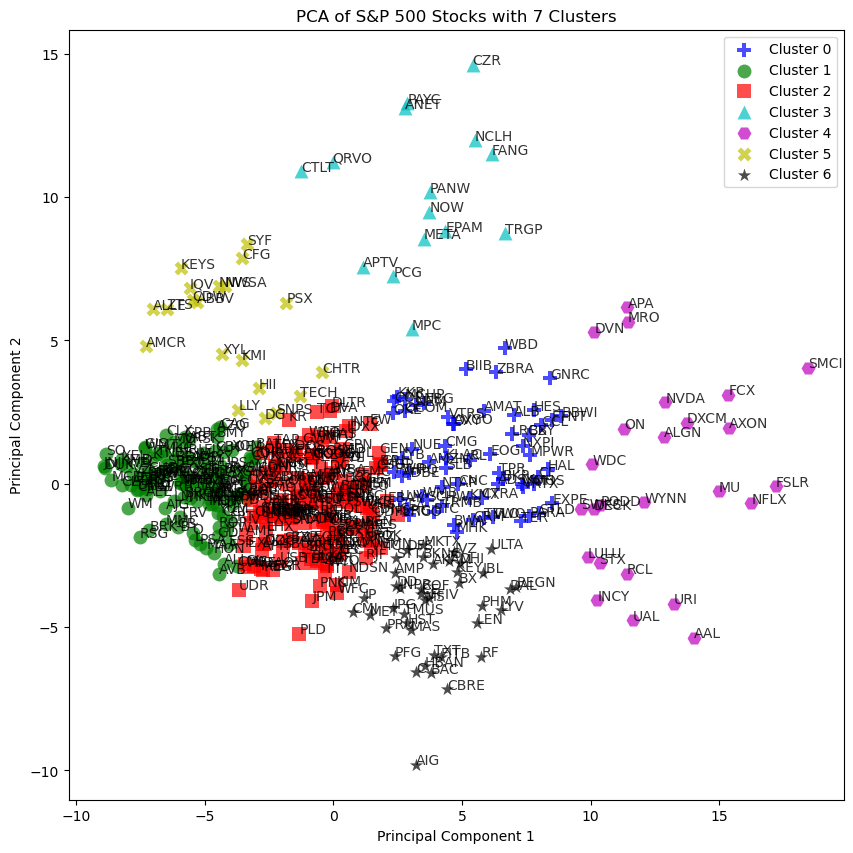

In [13]:
# Plot the clusters after outlier reduction
markers = ['P','o', 's', '^', 'H', 'X', '*']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 10))
for cluster_label in np.unique(reduced_labels):
    cluster_indices = np.where(reduced_labels == cluster_label)
    plt.scatter(reduced_data[cluster_indices, 0], reduced_data[cluster_indices, 1], 
                marker=markers[cluster_label], color=colors[cluster_label], s=100, lw=0, alpha=0.7, edgecolor='k', label=f'Cluster {cluster_label}')

# Add the ticker symbol
for i, ticker in enumerate(reduced_tickers):
    plt.annotate(ticker, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=10, alpha=0.8)

plt.title('PCA of S&P 500 Stocks with 7 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [14]:
# Calculate cluster sizes
cluster_sizes = pd.Series(reduced_labels).value_counts()

# Calculate within-cluster variance
cluster_variance = pd.DataFrame(reduced_data).groupby(reduced_labels).var().mean(axis=1)

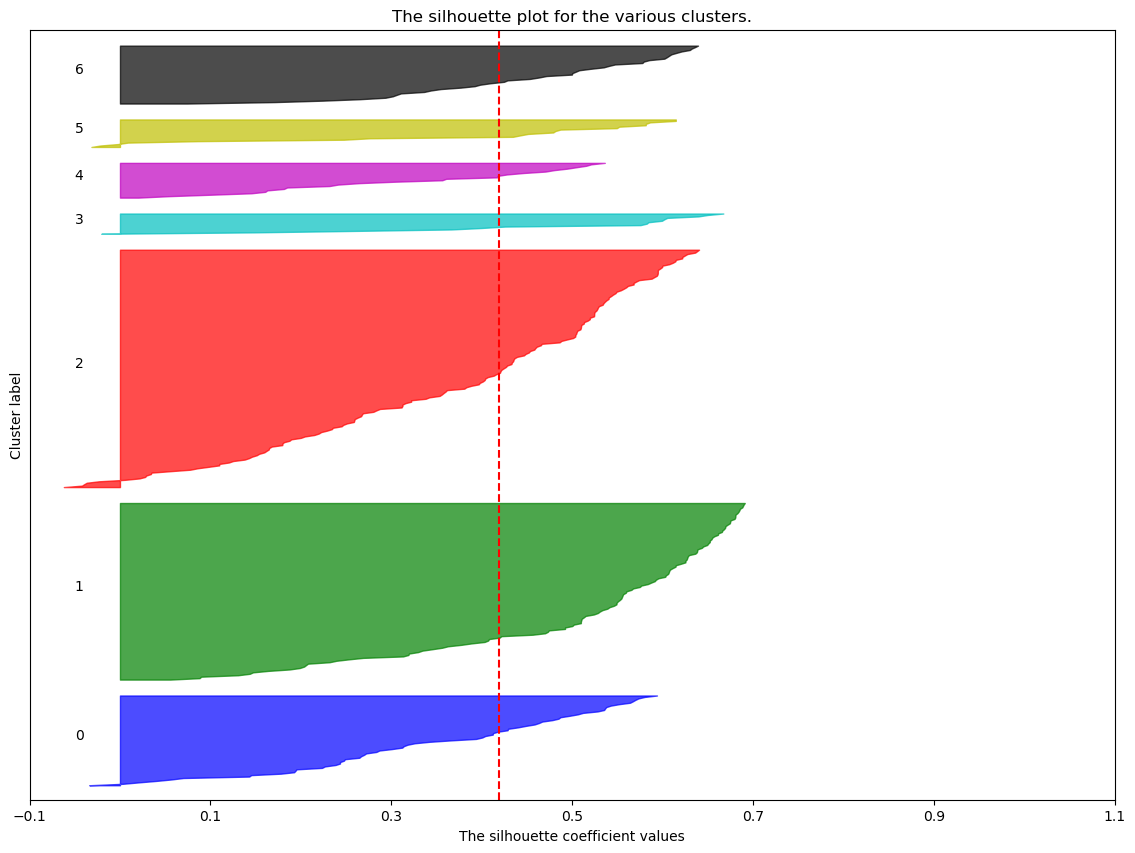

Cluster Sizes:
2    165
1    123
0     63
6     41
4     25
5     20
3     15
dtype: int64

Cluster Variance:
0    3.282769
1    1.671478
2    2.177563
3    5.646017
4    8.548267
5    3.631270
6    2.482749
dtype: float64


In [15]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Below code from scikit documentation

silhouette_avg = silhouette_score(reduced_data, reduced_labels)
fig, ax1 = plt.subplots(1, 1, figsize=(14, 10))

# The silhouette coefficient can range from -1, 1 but in this example, all the coefficients are positive
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(reduced_data) + (7 + 1) * 10])

# Compute the silhouette scores for each sample
silhouette_values = silhouette_samples(reduced_data, reduced_labels)

y_lower = 10
for i in range(7):
    ith_cluster_silhouette_values = silhouette_values[reduced_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i]
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()

# Show the result for cluster size and variance 
print("Cluster Sizes:")
print(cluster_sizes)
print("\nCluster Variance:")
print(cluster_variance)

**Observations:**

cluster 1,2,6 are well defined.

In [16]:
# Read the S&P 500 companies list from Wikipedia
tickers_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Extract the 'Symbol' and 'GICS Sector' columns
tickers_df['Symbol'] = tickers_df['Symbol'].str.replace('.', '-')  # Replace '.' with '-' for Yahoo Finance format
tickers_df = tickers_df[['Symbol', 'GICS Sector']]

/var/folders/hh/y_v1hz5n2xn1vh3yzx5r1hqw0000gn/T/ipykernel_83614/1725049321.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tickers_df['Symbol'] = tickers_df['Symbol'].str.replace('.', '-')  # Replace '.' with '-' for Yahoo Finance format


In [17]:
#create dictionary to include ticker name, cluster number.
ticker_cluster_df = pd.DataFrame({
    'Ticker': reduced_tickers,
    'Cluster': reduced_labels
})

In [18]:
# Consolidate the industry information
consolidated_df = pd.merge(ticker_cluster_df, tickers_df, how='left', left_on='Ticker', right_on='Symbol')

# Select the columns
tickers_clusters_df = consolidated_df[['Ticker', 'Cluster', 'GICS Sector']]
#rename columns
tickers_clusters_df.rename(columns={'GICS Sector': 'Industry'}, inplace=True)

tickers_clusters_df.head()

/var/folders/hh/y_v1hz5n2xn1vh3yzx5r1hqw0000gn/T/ipykernel_83614/122582883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickers_clusters_df.rename(columns={'GICS Sector': 'Industry'}, inplace=True)


,Ticker,Cluster,Industry
0,ADBE,0,Information Technology
1,ADSK,0,Information Technology
2,ALB,0,Materials
3,AMAT,0,Information Technology
4,AMZN,0,Consumer Discretionary


In [19]:
# Calculate the average return for each stock
average_return = quarterly_return.mean(axis=1).reset_index()
average_return.columns = ['Ticker', 'Average Return']

# Calculate the average return and volatility for each stock
average_return = quarterly_return.mean(axis=1).reset_index()
average_return.columns = ['Ticker', 'Average Return']
average_volatility = quarterly_volatility.mean(axis=1).reset_index()
average_volatility.columns = ['Ticker', 'Average Volatility']

# Merge the average returns and volatility with the cluster information
consolidated_df = pd.merge(tickers_clusters_df, average_return, on='Ticker')
consolidated_df = pd.merge(consolidated_df, average_volatility, on='Ticker')

In [20]:
# Normalized the Data
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [21]:
consolidated_df['Normalized Return'] = consolidated_df.groupby('Cluster')['Average Return'].transform(normalize)
consolidated_df['Normalized Volatility'] = consolidated_df.groupby('Cluster')['Average Volatility'].transform(lambda x: (x.max() - x) / (x.max() - x.min()))

# Combine the normalized scores
consolidated_df['Combined Score'] = consolidated_df['Normalized Return'] + consolidated_df['Normalized Volatility']

In [22]:
# Select the top five stocks for each cluster based on the combined score
top_stocks_per_cluster_normalized = consolidated_df.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Combined Score')).reset_index(drop=True)
top_stocks_per_cluster_normalized = top_stocks_per_cluster_normalized[['Cluster', 'Ticker', 'Industry', 'Average Return', 'Average Volatility', 'Normalized Return', 'Normalized Volatility', 'Combined Score']]
top_stocks_per_cluster_normalized

,Cluster,Ticker,Industry,Average Return,Average Volatility,Normalized Return,Normalized Volatility,Combined Score
0,0,AVGO,Information Technology,0.090363,0.287997,1.000000,0.711209,1.711209
1,0,KKR,Financials,0.057990,0.253263,0.581063,1.000000,1.581063
2,0,FICO,Information Technology,0.083237,0.299687,0.907788,0.614013,1.521801
3,0,AMZN,Consumer Discretionary,0.079297,0.299242,0.856794,0.617711,1.474505
4,0,LYB,Materials,0.051753,0.257431,0.500361,0.965339,1.465700
5,1,COST,Consumer Staples,0.051506,0.181229,0.775906,0.633379,1.409285
6,1,WM,Industrials,0.041629,0.163858,0.599496,0.809149,1.408645
7,1,AJG,Financials,0.049511,0.181181,0.740263,0.633861,1.374125
8,1,CTAS,Industrials,0.064054,0.211563,1.000000,0.326421,1.326421
9,1,MCD,Consumer Discretionary,0.033081,0.157091,0.446832,0.877626,1.324458


In [23]:
# Well-Defined Clusters: 1, 2 and 6.
Well_Defined_top_stocks = top_stocks_per_cluster_normalized[top_stocks_per_cluster_normalized['Cluster'].isin([1, 2, 6])]
Well_Defined_top_stocks

,Cluster,Ticker,Industry,Average Return,Average Volatility,Normalized Return,Normalized Volatility,Combined Score
5,1,COST,Consumer Staples,0.051506,0.181229,0.775906,0.633379,1.409285
6,1,WM,Industrials,0.041629,0.163858,0.599496,0.809149,1.408645
7,1,AJG,Financials,0.049511,0.181181,0.740263,0.633861,1.374125
8,1,CTAS,Industrials,0.064054,0.211563,1.000000,0.326421,1.326421
9,1,MCD,Consumer Discretionary,0.033081,0.157091,0.446832,0.877626,1.324458
10,2,ORLY,Consumer Discretionary,0.065840,0.226796,0.778991,0.839219,1.618210
11,2,CPRT,Industrials,0.059635,0.223613,0.699340,0.875939,1.575279
12,2,AAPL,Information Technology,0.079862,0.248375,0.958990,0.590216,1.549205
13,2,DHR,Health Care,0.052720,0.219029,0.610582,0.928840,1.539422
14,2,TDG,Industrials,0.083056,0.253578,1.000000,0.530181,1.530181


In [25]:
# Save data to file (Excel)
Well_Defined_top_stocks.to_excel("Well_Defined_top_stocks.xlsx")